# クラスタリング: 特徴量選択の調整とクラスタ解釈

## データ準備

In [2]:
import os, pathlib, pickle, math, itertools, copy
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import linalg
from scipy.stats import percentileofscore
import matplotlib as mpl
from sklearn import mixture

In [3]:
sampFreq = 100 # サンプリング単位

In [15]:
# フォルダのパス
PATH_DATA_PRO_SUB2_PKL = pathlib.Path("../data/processed/subject02/pickle") 
PATH_DATA_PRO_SUB2 = pathlib.Path("../data/processed/subject02") 

In [19]:
# pickleファイルを読み込んだ結果を返す関数
def read_pickle(path):
    with open(path, "rb") as f:
        return pickle.load(f)
    
lsNameCode17 = read_pickle(PATH_DATA_PRO_SUB2_PKL/"20190702_lsNameCode17_sampFreq100.pkl")
lsNameEnglishCode17 = read_pickle(PATH_DATA_PRO_SUB2_PKL/"20190702_lsNameEnglishCode17_sampFreq100.pkl")
lsNpCanResampled17 = read_pickle(PATH_DATA_PRO_SUB2_PKL/"20190702_lsNpCanResampled17_sampFreq100.pkl")
timeSeriesStart2End = read_pickle(PATH_DATA_PRO_SUB2_PKL/"20190702_timeSeriesStart2EndUse23_sampFreq100.pkl")
pdFeatureProfile = read_pickle(PATH_DATA_PRO_SUB2_PKL/"20190702_pdFeatureProfileUse23_sampFreq100.pkl")

In [5]:
# 各特徴量の分布を再度確認
for ctFeature in range(len(lsNpCanResampled17)):
    print(ctFeature)
    print(lsNameEnglishCode17[ctFeature])
    print(pd.DataFrame(lsNpCanResampled17[ctFeature]).describe())

0
Acceleration_Sensor_Value_1EF57
                   0
count  369900.000000
mean       -0.011224
std         0.609540
min        -4.312500
25%        -0.187500
50%         0.000000
75%         0.062500
max         3.812500
1
Accelerator_Actual_Position_12217
                   0
count  369900.000000
mean       13.176661
std        15.261049
min         0.000000
25%         0.000000
50%         9.411765
75%        21.960784
max       100.000000
2
Brake_Pedal_Switch_Active_31802
                   0
count  369900.000000
mean        0.283090
std         0.449415
min         0.000000
25%         0.000000
50%         0.000000
75%         1.000000
max         1.000000
3
Engine_Coolant_Temperature_31017
                   0
count  369900.000000
mean       84.617707
std         8.435573
min        49.000000
25%        86.000000
50%        87.000000
75%        88.000000
max        92.000000
4
Engine_Speed_12417
                   0
count  369900.000000
mean     1647.650944
std       629.712996


**!線形補間前で確認!**

In [10]:
# 値の種類の数
lsNunique = list()
for ctFeature in range(len(lsNpCanResampled17)):
    thisNunique = pd.Series(lsNpCanResampled17[ctFeature]).nunique()
    print("nunique=" + str(thisNunique) + ". ctFeature=" + str(ctFeature) + " " + lsNameEnglishCode17[ctFeature])
    lsNunique.append(thisNunique)

nunique=48734. ctFeature=0 Acceleration_Sensor_Value_1EF57
nunique=50959. ctFeature=1 Accelerator_Actual_Position_12217
nunique=2177. ctFeature=2 Brake_Pedal_Switch_Active_31802
nunique=6375. ctFeature=3 Engine_Coolant_Temperature_31017
nunique=147194. ctFeature=4 Engine_Speed_12417
nunique=13190. ctFeature=5 Fuel_Level_Actual_Percent_3B947
nunique=3473. ctFeature=6 Fuel_Level_Percent_Average_3B957
nunique=85087. ctFeature=7 Lateral_Sensor_Value_1EF61
nunique=35185. ctFeature=8 Master_Cylinder_Pressure_1AF67
nunique=4449. ctFeature=9 Mileage_Information_46003
nunique=7134. ctFeature=10 Outside_Air_Temperature_3D177
nunique=62. ctFeature=11 Park_Brake_Switch_Active_3D016
nunique=89893. ctFeature=12 Steering_Wheel_Absolute_Angle_11947
nunique=78. ctFeature=13 Turn_Left_SW_3C112
nunique=714. ctFeature=14 Turn_Right_SW_3C111
nunique=295450. ctFeature=15 Vehicle_Speed_31417
nunique=349727. ctFeature=16 Yaw_Rate_1(learmed_data)_1EF37


## 使用する特徴量を一部除外(スイッチ系など)

In [11]:
# 使用する特徴量の設定
isRemoveSwitchVariables = True # スイッチ系の特徴量を除くか
isRemoveMileageFuel = True # Mileage, Fuelの特徴量を除くか
isFunMaxOnly = True # ダウンサンプリングする際に、最大値のみを使用するか
isSelectFeaturesByCorrelation = True # 相関の高いペアを除くか

In [26]:
pdSeriesNameEnglishCode17.str.contains("|")

0     True
1     True
2     True
3     True
4     True
5     True
6     True
7     True
8     True
9     True
10    True
11    True
12    True
13    True
14    True
15    True
16    True
dtype: bool

In [31]:
# スイッチ系の特徴量を削除した場合に残る特徴量を確認
pdSeriesNameEnglishCode17 = pd.Series(lsNameEnglishCode17)

condition_Switch = ["Switch","SW"] if isRemoveMileageFuel else [] # スイッチ系の語句
condition_MileageFuel = ["Mileage","Fuel"] if isRemoveMileageFuel else [] # 燃料/マイレージ系の語句

# 残った特徴量の名前のSeries
boolStrSw = (pdSeriesNameEnglishCode17.str
             .contains("|".join(condition_MileageFuel + condition_Switch)))

# 特徴量の名前、削除対象か否か、値の種類数をまとめたDataFrame
pdNameCode17BoolStrSw = pd.DataFrame({
                'nameEnglishCode17':pdSeriesNameEnglishCode17, 
                'boolStrSw':pd.Series(boolStrSw),
                'nunique':pd.Series(lsNunique),
                })

# csvとして保存
pdNameCode17BoolStrSw.to_csv(PATH_DATA_PRO_SUB2/(
    "pdNameCode17BoolStrSw_" +  
    "Fuel_" + str(isRemoveMileageFuel)+
    "isFunMaxOnly_" + str(isFunMaxOnly) + ".csv"
    ))

print(pdNameCode17BoolStrSw)

                      nameEnglishCode17  boolStrSw  nunique
0       Acceleration_Sensor_Value_1EF57      False    48734
1     Accelerator_Actual_Position_12217      False    50959
2       Brake_Pedal_Switch_Active_31802       True     2177
3      Engine_Coolant_Temperature_31017      False     6375
4                    Engine_Speed_12417      False   147194
5       Fuel_Level_Actual_Percent_3B947       True    13190
6      Fuel_Level_Percent_Average_3B957       True     3473
7            Lateral_Sensor_Value_1EF61      False    85087
8        Master_Cylinder_Pressure_1AF67      False    35185
9             Mileage_Information_46003       True     4449
10        Outside_Air_Temperature_3D177      False     7134
11       Park_Brake_Switch_Active_3D016       True       62
12  Steering_Wheel_Absolute_Angle_11947      False    89893
13                   Turn_Left_SW_3C112       True       78
14                  Turn_Right_SW_3C111       True      714
15                  Vehicle_Speed_31417 

In [32]:
# スイッチ系の特徴量を削除

# 残る特徴量一覧
vecIndexTrueSw = [i for i, x in enumerate(pdNameCode17BoolStrSw.boolStrSw) if not x]
print(vecIndexTrueSw)
print(str(len(lsNameCode17)) + " is the length of the target variables to use before removal")

# 残す特徴量のみ抽出
if isRemoveSwitchVariables or isRemoveMileageFuel:
    lsNameCode17 = [lsNameCode17[i] for i in vecIndexTrueSw ]
    lsNameEnglishCode17 = [lsNameEnglishCode17[i] for i in vecIndexTrueSw ]
    lsNpCanResampled17 = [lsNpCanResampled17[i] for i in vecIndexTrueSw ]

print(str(len(lsNameCode17)) + " is the length of the target variables after removal")

[0, 1, 3, 4, 7, 8, 10, 12, 15, 16]
17 is the length of the target variables to use before removal
10 is the length of the target variables after removal


## 前処理

### 差分を計算

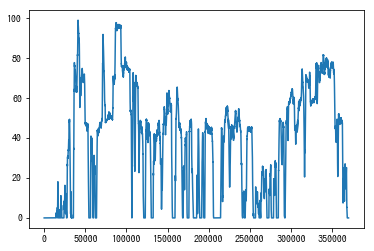

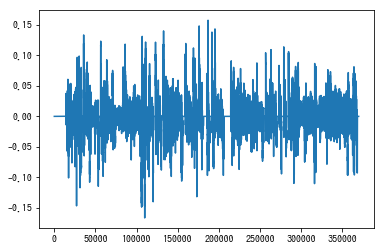

In [33]:
# 差分(微分)を計算
lsNpCanResampledDiff17 = list()
lsNameCodeDiff17 = list()
for ctFeature in list(range(len(lsNameCode17))):
    npArraySpeed = lsNpCanResampled17[ctFeature]
    npArrayKasoku = np.diff(npArraySpeed)
    npArrayKasoku = np.insert(arr=npArrayKasoku, obj=0, values=npArrayKasoku[0])
    lsNpCanResampledDiff17.append(npArrayKasoku)
    lsNameCodeDiff17.append(lsNameCode17[ctFeature] + "_diff" )

# 試しに31417をプロット
indexOneFeature = np.where(np.array(lsNameCode17) == "31417")[0][0]
plt.plot(lsNpCanResampled17[indexOneFeature])
plt.show()
indexOneFeature = np.where(np.array(lsNameCodeDiff17) == "31417_diff")[0][0]
plt.plot(lsNpCanResampledDiff17[indexOneFeature])
plt.show()

### ダウンサンプリング

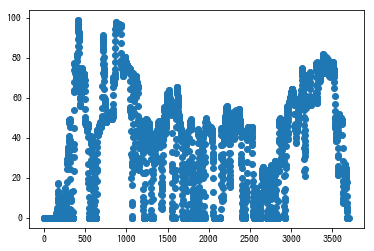

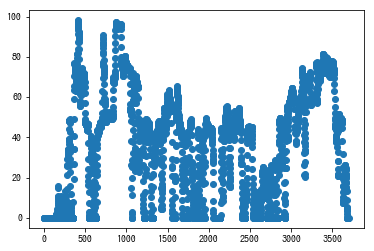

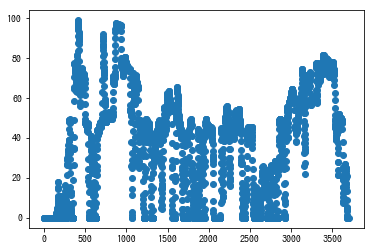

In [34]:
# 1秒毎にまとめる関数
def funAggUnitTime(timeSeriesStart2End, npArrayOneFeature):
    npOneFeatureMillisec = np.c_[timeSeriesStart2End, npArrayOneFeature]
    pdSpeedKasokuMilliSec = pd.DataFrame(npOneFeatureMillisec)
    pdSpeedKasokuMilliSec['timeCeilSec'] = [
        math.ceil(i) for i in npOneFeatureMillisec[:, 0]]
    pdSpeedKasokuMilliSec = pdSpeedKasokuMilliSec[[1, "timeCeilSec"]]
    pdSpeedKasokuMilliSec.index = timeSeriesStart2End

    pdSpeedSecMean = pdSpeedKasokuMilliSec.groupby('timeCeilSec').mean()
    pdSpeedSecMin = pdSpeedKasokuMilliSec.groupby('timeCeilSec').min()
    pdSpeedSecMax = pdSpeedKasokuMilliSec.groupby('timeCeilSec').max()

    return(pdSpeedSecMean, pdSpeedSecMin, pdSpeedSecMax)

# 試しに31417をプロット
indexOneFeature = np.where(np.array(lsNameCode17) == "31417")[0][0]
npArrayOneFeature = lsNpCanResampled17[indexOneFeature]
pdSpeedSecMean, pdSpeedSecMin, pdSpeedSecMax = funAggUnitTime(timeSeriesStart2End, npArrayOneFeature)
plt.plot(pdSpeedSecMean, "o")
plt.show()
plt.plot(pdSpeedSecMin, "o")
plt.show()
plt.plot(pdSpeedSecMax, "o")
plt.show()

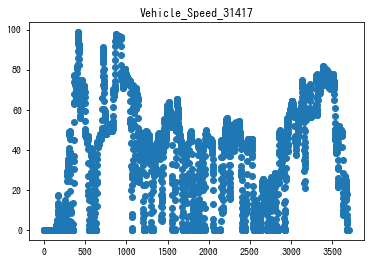

In [35]:
# 全変数について、1秒毎にまとめる
lsPdSpeedSecMean = list()
lsPdSpeedSecMin = list()
lsPdSpeedSecMax = list()
for ctFeature in list(range(len(lsNpCanResampled17))):
    npArrayOneFeature = lsNpCanResampled17[ctFeature]
    pdSpeedSecMean, pdSpeedSecMin, pdSpeedSecMax = funAggUnitTime(timeSeriesStart2End, npArrayOneFeature)
    lsPdSpeedSecMean.append(pdSpeedSecMean)
    lsPdSpeedSecMin.append(pdSpeedSecMin)
    lsPdSpeedSecMax.append(pdSpeedSecMax)

# 試しにプロット
ctFeature = indexOneFeature
plt.plot(lsPdSpeedSecMean[ctFeature], "o")
plt.title(lsNameEnglishCode17[ctFeature])
plt.show()

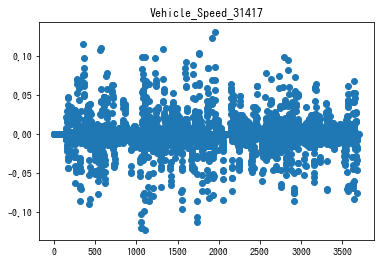

In [36]:
# 全変数の微分値について、1秒毎にまとめる
lsPdSpeedSecMeanDiff = list()
lsPdSpeedSecMinDiff = list()
lsPdSpeedSecMaxDiff = list()
for ctFeature in list(range(len(lsNpCanResampledDiff17))):
    npArrayOneFeature = lsNpCanResampledDiff17[ctFeature]
    pdSpeedSecMean, pdSpeedSecMin, pdSpeedSecMax = funAggUnitTime(timeSeriesStart2End, npArrayOneFeature)
    lsPdSpeedSecMeanDiff.append(pdSpeedSecMean)
    lsPdSpeedSecMinDiff.append(pdSpeedSecMin)
    lsPdSpeedSecMaxDiff.append(pdSpeedSecMax)

# 試しにひとつプロット
ctFeature =indexOneFeature
plt.plot(lsPdSpeedSecMeanDiff[ctFeature], "o")
plt.title(lsNameEnglishCode17[ctFeature])
plt.show()

## クラスタリング

In [38]:
# 混合正規分布
color_iter = itertools.cycle(['r', 'c', 'cornflowerblue', 'g',
                              'darkorange', 'y', 'm'])

# 結果をプロットする関数
def plot_results(X, Y_, means, covariances, index, title, mySize):
    splot = plt.subplot(1, 1, 1 + index)
    for i, (mean, covar, color) in enumerate(zip(
            means, covariances, color_iter)):
        v, w = linalg.eigh(covar)
        v = 2. * np.sqrt(2.) * np.sqrt(v)
        u = w[0] / linalg.norm(w[0])
        if not np.any(Y_ == i):
            continue
        plt.scatter(X[Y_ == i, 0], X[Y_ == i, 1], s=mySize, color=color)

        # Plot an ellipse to show the Gaussian component
        angle = np.arctan(u[1] / u[0])
        angle = 180. * angle / np.pi  # convert to degrees
        ell = mpl.patches.Ellipse(mean, v[0], v[1], 180. + angle, color=color)
        ell.set_clip_box(splot.bbox)
        ell.set_alpha(0.5)
        splot.add_artist(ell)

    plt.title(title)

In [39]:
# 散布図をプロットする関数
def runGmmTwoDimensions(X, numClusters, isSave = 0, mySize=20, isShow=1):
    np.random.seed(0)
    # Fit a Gaussian mixture with EM using five components
    gmm = mixture.GaussianMixture(n_components=numClusters, covariance_type='full').fit(X)
    if isShow == 1:
        fig = plt.figure(figsize=(8, 4), dpi=100)

        strTitle = ('Gaussian Mixture' + "_feature" + str(ctFeature) + "_cluster" + str(numClusters) )
        plot_results(X, gmm.predict(X), gmm.means_, gmm.covariances_, 0, strTitle,
        mySize = mySize)
        if isSave == 0:
            plt.show()
        else:
            myDpi = 100
            strObj = PATH_DATA_PRO_SUB2/("20190708_" +
                    "plot_GMM_DPI" + str(myDpi) + 
                    "feature" + str(ctFeature)  + 
                    "cluster" + str(numClusters)  + 
                    ".png")
            fig.savefig(strObj, dpi=myDpi, bbox_inches="tight")
            # plt.close(fig)    # close the figure when you don't want to show it in Jupyter
    return(gmm.bic(X))

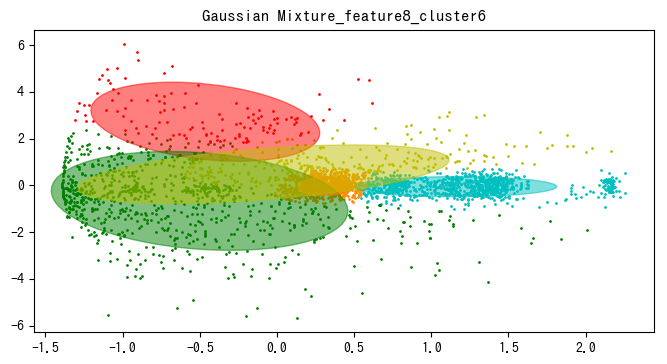

2569.7537181913503


In [40]:
# 試しに速度と速度の差分を使ってクラスタリング

# 標準化するための関数
def myStandardize(lsPdSpeedSecMean):
    lsPdSpeedSecMeanScaled = list() 
    for ctFeature in list(range(len(lsPdSpeedSecMean))):
        oneFeature = lsPdSpeedSecMean[ctFeature]
        oneFeature = oneFeature - oneFeature.mean()
        oneFeature = oneFeature / np.std(oneFeature)
        lsPdSpeedSecMeanScaled.append(oneFeature)
    return(lsPdSpeedSecMeanScaled)

# 速度と速度の差分の平均、最小値、最大値について、標準化
lsPdSpeedSecMeanScaled = myStandardize(lsPdSpeedSecMean)
lsPdSpeedSecMinScaled = myStandardize(lsPdSpeedSecMin)
lsPdSpeedSecMaxScaled = myStandardize(lsPdSpeedSecMax)
lsPdSpeedSecMeanDiffScaled = myStandardize(lsPdSpeedSecMeanDiff)
lsPdSpeedSecMinDiffScaled = myStandardize(lsPdSpeedSecMinDiff)
lsPdSpeedSecMaxDiffScaled = myStandardize(lsPdSpeedSecMaxDiff)

# 試しに一つクラスタリング
ctFeature = indexOneFeature # Speed
npOneFeatureSec = np.c_[lsPdSpeedSecMeanScaled[ctFeature], 
                        lsPdSpeedSecMeanDiffScaled[ctFeature]]
# クラスタ数: 6
outGmmBic = runGmmTwoDimensions(X = npOneFeatureSec, numClusters = 6, mySize = 1)
print(outGmmBic)

21041.370292901818
17910.065114590143
3101.2711152343454
2919.1210745245976
2430.012259207376
2569.7537181913503
2460.2913903462977
2372.7431822988956
2382.29183406346
2426.1287330313453
2569.393989889303
2581.5194994436497
2446.364435842847
2306.7671374452493
2356.3076757127064
2357.054734622549
2377.0233121979536
2214.821683391463
2219.1776101353803
2243.581982382904
2221.748727708963
2272.1850011810457
2316.227279165626
2369.6337990368465


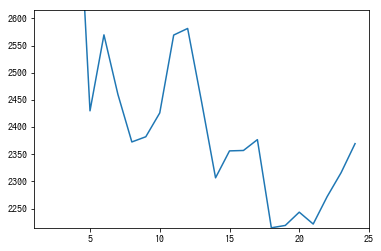

In [41]:
# 試しに速度と速度の差分を使って、クラスタ数1~25までクラスタリング
lsGmmBicByCluster = list()
myRangeMin = 1
myRangeMax = 25
for ctCluster in list(range(myRangeMin, myRangeMax)):
    outGmmBic = runGmmTwoDimensions(X = npOneFeatureSec, numClusters = ctCluster, 
    isSave = 1, mySize = 2, isShow = 0)
    lsGmmBicByCluster.append(outGmmBic)
    print(outGmmBic)
plt.plot(list(range(myRangeMin, myRangeMax)), lsGmmBicByCluster)
plt.xlim((myRangeMin, myRangeMax))
plt.ylim((pd.Series(lsGmmBicByCluster).min() , pd.Series(lsGmmBicByCluster).min() + 400))
plt.show()

In [44]:
# 変数のリストを一個にまとめる関数
def myConvertList2DataFrame(lsPdSpeedSecMeanScaled, strFun):
    featureIndexToUse = pd.Series(range(0,len(lsPdSpeedSecMeanScaled)))
    dfStepwiseInput = pd.concat([lsPdSpeedSecMeanScaled[i] for i in featureIndexToUse], axis=1)
    dfStepwiseInput.columns = (pd.Series(lsNameEnglishCode17) + strFun)
    return(dfStepwiseInput)

dfStepwiseInput_mean = myConvertList2DataFrame(lsPdSpeedSecMeanScaled, strFun = "_mean")
dfStepwiseInput_min = myConvertList2DataFrame(lsPdSpeedSecMinScaled, strFun = "_min")
dfStepwiseInput_max = myConvertList2DataFrame(lsPdSpeedSecMaxScaled, strFun = "_max")
dfStepwiseInput_diff_mean = myConvertList2DataFrame(lsPdSpeedSecMeanDiffScaled, strFun = "_diff_mean")
dfStepwiseInput_diff_min = myConvertList2DataFrame(lsPdSpeedSecMinDiffScaled, strFun = "_diff_min")
dfStepwiseInput_diff_max = myConvertList2DataFrame(lsPdSpeedSecMaxDiffScaled, strFun = "_diff_max")

10


In [45]:
# 最小、平均、最大を一つのDFにまとめる。
if isFunMaxOnly == 0:
    dfStepwiseInput = pd.concat([   dfStepwiseInput_mean, 
                                    dfStepwiseInput_min,
                                    dfStepwiseInput_max,
                                    dfStepwiseInput_diff_mean,
                                    dfStepwiseInput_diff_min,
                                    dfStepwiseInput_diff_max
                                    ], axis=1)
else:
    dfStepwiseInput = pd.concat([   
                                    dfStepwiseInput_max,
                                    dfStepwiseInput_diff_max
                                    ], axis=1)
print(dfStepwiseInput.shape)

(3700, 20)


In [46]:
# 作図して確認。図は保存。
print(dfStepwiseInput.nunique())
lenColumnsStepwiseInput = len(dfStepwiseInput.columns)
maxCtSubplot = 5
ctPng = 0
myDpi = 100
for ctFeature in list(range(lenColumnsStepwiseInput)):
    ctSubplot = 1 + ( (ctFeature) % maxCtSubplot )
    print("ctFeature=" + str(ctFeature) + " ctSubplot=" + str(ctSubplot))
    if ctSubplot == 1:
        fig = plt.figure(figsize=(5, 10), dpi=100)
        ctPng = ctPng + 1
    pltFig = fig.add_subplot(maxCtSubplot, 1, ctSubplot)
    pltFig.plot(dfStepwiseInput.iloc[:,ctFeature], color="cyan")
    myStr = ("plot#" + str(ctFeature+1) + dfStepwiseInput.columns[ctFeature])
    pltFig.text(10, dfStepwiseInput.iloc[:,ctFeature].min(), myStr,
                size=10, color="black", zorder=10)
    pltFig.grid()
    if ( ctSubplot == maxCtSubplot) | (ctSubplot + 1 == lenColumnsStepwiseInput):
        # fig.show()
        strObj = PATH_DATA_PRO_SUB2/("20190805_" +
                                        "plot_check_if_categorical_DPI" + str(myDpi) + 
                                        "_PNG" + str(ctPng) + ".png")
        fig.savefig(strObj, dpi=myDpi, bbox_inches="tight")
        plt.close(fig)    # close the figure

Acceleration_Sensor_Value_1EF57_max              368
Accelerator_Actual_Position_12217_max            616
Engine_Coolant_Temperature_31017_max             104
Engine_Speed_12417_max                          2331
Lateral_Sensor_Value_1EF61_max                   643
Master_Cylinder_Pressure_1AF67_max               907
Outside_Air_Temperature_3D177_max                 70
Steering_Wheel_Absolute_Angle_11947_max         1102
Vehicle_Speed_31417_max                         3068
Yaw_Rate_1(learmed_data)_1EF37_max              3621
Acceleration_Sensor_Value_1EF57_diff_max        2130
Accelerator_Actual_Position_12217_diff_max      1868
Engine_Coolant_Temperature_31017_diff_max        261
Engine_Speed_12417_diff_max                     3451
Lateral_Sensor_Value_1EF61_diff_max             2460
Master_Cylinder_Pressure_1AF67_diff_max         1214
Outside_Air_Temperature_3D177_diff_max           153
Steering_Wheel_Absolute_Angle_11947_diff_max    2576
Vehicle_Speed_31417_diff_max                  

In [ ]:
# %%
# hist plot check to remove category-like variables
# Aug. 5
print(dfStepwiseInput.nunique())
lenColumnsStepwiseInput = len(dfStepwiseInput.columns)
maxCtSubplot = 5
ctPng = 0
myDpi = 100
for ctFeature in list(range(lenColumnsStepwiseInput)):
    ctSubplot = 1 + ( (ctFeature) % maxCtSubplot )
    print("ctFeature=" + str(ctFeature) + " ctSubplot=" + str(ctSubplot))
    if ctSubplot == 1:
        fig = plt.figure(figsize=(5, 10), dpi=100)
        ctPng = ctPng + 1
    pltFig = fig.add_subplot(maxCtSubplot, 1, ctSubplot)
    pltFig.hist(dfStepwiseInput.iloc[:,ctFeature], color="cyan", bins=100)
    myStr = ("plot#" + str(ctFeature+1) + dfStepwiseInput.columns[ctFeature])
    pltFig.text(dfStepwiseInput.iloc[:,ctFeature].min(), 0, myStr,
                size=10, color="black", zorder=10)
    pltFig.grid()
    if ( ctSubplot == maxCtSubplot) | (ctSubplot + 1 == lenColumnsStepwiseInput):
        # fig.show()
        strObj = PATH_DATA_PRO_SUB2/("20190805_" +
                                        "plot_hist_check_if_categorical_DPI" + str(myDpi) + 
                                        "_PNG" + str(ctPng) + ".png")
        fig.savefig(strObj, dpi=myDpi, bbox_inches="tight")
        plt.close(fig)    # close the figure
print("plot files have been saved in files")

In [48]:
# 与えられたXとクラスタ数に対して、GMMのBICを返す関数
def getGmmBic(X, numClusters):
    np.random.seed(0)
    # Fit a Gaussian mixture with EM 
    gmm = mixture.GaussianMixture(n_components=numClusters, covariance_type='full').fit(X)
    return(gmm.bic(X))

In [49]:
# ステップワイズ
myNumClusters = 5
remaining = set(dfStepwiseInput.columns) # まだStepwiseに入れていないカラム名
selected = []  # 採用が確定された要因
current_score, best_new_score = (10**10, 10**10) # 初期値で大きい値を仮入れ。
ctWhile = 0
while remaining and current_score == best_new_score and ctWhile<1000:
    ctWhile = ctWhile + 1 # while文が暴走した時に1000周で停止。
    print("ctWhile" + str(ctWhile) + " start ===")
    scores_with_candidates = []
    for candidate in sorted(remaining):
        # 残っている要因を1つずつ追加したときのAICを計算
        selectedTemp = copy.deepcopy(selected)
        selectedTemp.append(candidate)
        outGmmBic = getGmmBic(X = pd.DataFrame(
                            dfStepwiseInput[selectedTemp]), 
                            numClusters=myNumClusters)
        scores_with_candidates.append((outGmmBic, candidate))

    # 最もBICが小さかった要因をbest_candidateとする
    scores_with_candidates.sort()
    best_new_score, best_candidate = scores_with_candidates[0]

    # 候補要因追加でBICが下がったならば，それを確定要因として追加する
    if best_new_score < current_score:
        remaining.remove(best_candidate)
        selected.append(best_candidate)
        current_score = best_new_score
        print(" BIC改善！（より小さいBIC発見）。現特徴数＝" + str(len(selected)))
    else:
        print("=====中止。BIC不変化。（BICが小さくならなかった。）")

    print("BIC = " + str(best_new_score) + "_")
    print( selected)

ctWhile1 start ===
 BIC改善！（より小さいBIC発見）。現特徴数＝1
BIC = -41492.643872425295_
['Outside_Air_Temperature_3D177_diff_max']
ctWhile2 start ===
 BIC改善！（より小さいBIC発見）。現特徴数＝2
BIC = -78689.66072054891_
['Outside_Air_Temperature_3D177_diff_max', 'Engine_Coolant_Temperature_31017_diff_max']
ctWhile3 start ===
 BIC改善！（より小さいBIC発見）。現特徴数＝3
BIC = -94064.51804765206_
['Outside_Air_Temperature_3D177_diff_max', 'Engine_Coolant_Temperature_31017_diff_max', 'Master_Cylinder_Pressure_1AF67_max']
ctWhile4 start ===
 BIC改善！（より小さいBIC発見）。現特徴数＝4
BIC = -115012.60999690092_
['Outside_Air_Temperature_3D177_diff_max', 'Engine_Coolant_Temperature_31017_diff_max', 'Master_Cylinder_Pressure_1AF67_max', 'Master_Cylinder_Pressure_1AF67_diff_max']
ctWhile5 start ===
=====中止。BIC不変化。（BICが小さくならなかった。）
BIC = -108326.7791630804_
['Outside_Air_Temperature_3D177_diff_max', 'Engine_Coolant_Temperature_31017_diff_max', 'Master_Cylinder_Pressure_1AF67_max', 'Master_Cylinder_Pressure_1AF67_diff_max']


defined


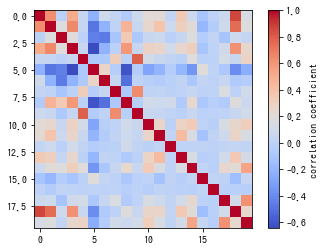

In [51]:
# 特徴量同士の相関を確認
def heatmapTakeCorrMat(dfCorr):
    plt.imshow(dfCorr, interpolation='nearest', cmap=plt.cm.coolwarm)
    plt.colorbar(label='correlation coefficient')
    tick_marks = np.arange(len(dfCorr))
print("defined")

dfCorr20 = dfStepwiseInput.corr()
heatmapTakeCorrMat(dfCorr20)
dfCorr20.to_csv(PATH_DATA_PRO_SUB2/"dfCorr20.csv")

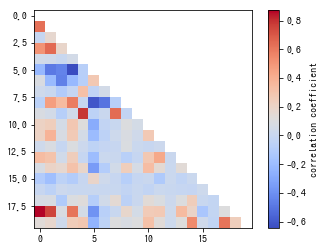

In [52]:
# 上三角を除いてプロットする場合
dfCorrTriUpper20 = dfCorr20.mask(np.triu(np.ones([len(dfCorr20)]*2, dtype=bool)))
heatmapTakeCorrMat(dfCorrTriUpper20)
dfCorrTriUpper20.to_csv(PATH_DATA_PRO_SUB2/"dfCorrTriUpper20.csv")

In [53]:
# 相関係数が0.9以上のペアを削除
dfCorrTriUpper20temp = copy.deepcopy(dfCorrTriUpper20)
dfCorrTriUpper20temp['dummy'] = 0 # to avoid the first row with no value to be removed
vecRowMaxCorr20 = dfCorrTriUpper20temp.max(axis=1)
myThreCorr23 = 0.9
vecRowMaxCorr20LowCorr = vecRowMaxCorr20[vecRowMaxCorr20<myThreCorr23]

In [54]:
if isSelectFeaturesByCorrelation == 1: # override the stepwise result if using correlation
    selected = [
        'Acceleration_Sensor_Value_1EF57_max', # 1
        'Accelerator_Actual_Position_12217_max',
        'Engine_Coolant_Temperature_31017_max', 
        'Engine_Speed_12417_max',
        'Lateral_Sensor_Value_1EF61_max', # 5
        'Master_Cylinder_Pressure_1AF67_max',
        'Outside_Air_Temperature_3D177_max',
        'Steering_Wheel_Absolute_Angle_11947_max', 
        'Vehicle_Speed_31417_max',
        # 'Yaw_Rate_1(learmed_data)_1EF37_max', # 10
        # 'Acceleration_Sensor_Value_1EF57_diff_max',
        'Accelerator_Actual_Position_12217_diff_max',
        # 'Engine_Coolant_Temperature_31017_diff_max',
        'Engine_Speed_12417_diff_max', 
        # 'Lateral_Sensor_Value_1EF61_diff_max', # 15
        'Master_Cylinder_Pressure_1AF67_diff_max',
        # 'Outside_Air_Temperature_3D177_diff_max',
        'Steering_Wheel_Absolute_Angle_11947_diff_max',
        # 'Vehicle_Speed_31417_diff_max',
        'Yaw_Rate_1(learmed_data)_1EF37_diff_max' # 20
        ] # 

pdSelected = pd.DataFrame(selected) #
pdSelected.columns = ["selected"]
pdSelected['isDiff'] = 0 
pdSelected['feature'] = pdSelected['selected']
for ctRow in list(range(len(pdSelected.index))):
    if pdSelected['selected'].iloc[ctRow][-5:] == "_diff":
        pdSelected['isDiff'].iloc[ctRow] = 1
        pdSelected['feature'].iloc[ctRow] = pdSelected['feature'].iloc[ctRow][:-5]

# join
pdSelected = pd.merge(pdSelected, pdFeatureProfile[['feature', 'featureName']], how = 'left')
pdSelected.to_csv("pdSelected_60minutes.csv")

done


In [55]:
# Block E8. create dataframe of best BIC model
pdBestBicData = dfStepwiseInput[selected]
pdBestBicData.iloc[:5, :3]

,Acceleration_Sensor_Value_1EF57_max,Accelerator_Actual_Position_12217_max,Engine_Coolant_Temperature_31017_max
timeCeilSec,,,
1,-0.129259,-0.993509,-4.227966
2,-0.129259,-0.993509,-4.227966
3,-0.129259,-0.993509,-4.227966
4,-0.129259,-0.993509,-4.227966
5,-0.129259,-0.993509,-4.227966


In [56]:
# %%
# Block D15. GMM (EM algorithm) two dimensions, loop try 1 to 15 clusters
lsGmmBicByCluster = list()
myRangeMin = 1
myRangeMax = 30
for ctCluster in list(range(myRangeMin, myRangeMax)):
    outGmmBic = runGmmTwoDimensions(X = np.array(pdBestBicData), numClusters = ctCluster, 
    isSave = 1, mySize = 2, isShow=0)
    lsGmmBicByCluster.append(outGmmBic)
    print(outGmmBic)

129099.00204751614
82872.43224103491
66350.25096926517
17523.548984897006
9673.159949208864
-6151.932447362807
6718.224853220294
-8927.8489989285
-9110.767821033744
-15902.140003953275
-25964.395307913805
-25551.157249798336
-26910.830219573567
-24566.255774678997
-23217.018767562055
-29510.79109442818
-24457.873611410338
-24532.429400956094
-25245.02446301865
-25156.288155978375
-25299.22651729773
-25632.02045793741
-24382.721451897258
-22122.008310341917
-24241.30257198831
-26517.643101988906
-27132.3578340419
-26722.72676675914
-25498.222972804695


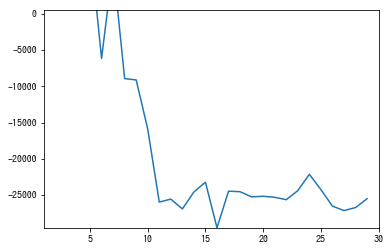

In [57]:
# %% 
plt.plot(list(range(myRangeMin, myRangeMax)), lsGmmBicByCluster)
plt.xlim((myRangeMin, myRangeMax))
plt.ylim((pd.Series(lsGmmBicByCluster).min() , pd.Series(lsGmmBicByCluster).min() + 30000))
plt.show()

In [58]:
# %%
# find minimum BIC
pdSeriesLsGmmBicByCluster = pd.Series(lsGmmBicByCluster)
# np.where(pdSeriesLsGmmBicByCluster,  pdSeriesLsGmmBicByCluster.min()
val, idx = min((val, idx) for (idx, val) in enumerate(pdSeriesLsGmmBicByCluster))
myNumClusters = idx + 1
print(myNumClusters)

16


In [59]:
# %%
# Block E9. Fit a Gaussian mixture with EM 
np.random.seed(0)
gmm = mixture.GaussianMixture(n_components = myNumClusters, 
                                covariance_type='full').fit(pdBestBicData)
vecClusterComponent = gmm.predict(pdBestBicData)
lenSelected = len(selected)

done


In [60]:
# %%
# Block E10. get time unit
timeUnit = 1
myTime = pd.Series(range(1, 1+len(pdBestBicData.index))) # *timeUnit)
myTime = timeUnit * myTime

/Users/localadmin/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


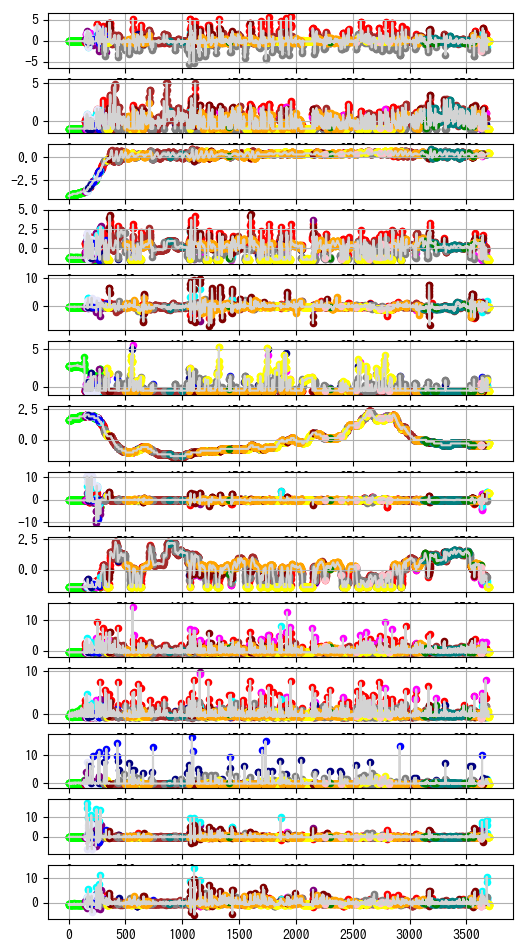

In [62]:
# %%
# Block E11. Plot the features in the best Stepwise model.
color_iter = itertools.cycle(['r', 'c', 'cornflowerblue', 'g',
                              'darkorange', 'y', 'm'])
color_iterFix = ([
    "red", "green", "yellow", "blue", "orange", 
    "purple", "cyan", "magenta", "lime", "pink", 
    "teal", "lavender", "brown", #"beige", 
    "maroon", # "mint", "olive", "apricot", 
    "navy", "grey", 
    "black" ,
    
    "red", "green", "yellow", "blue", "orange", 
    "purple", "cyan", "magenta", "lime", "pink", 
    "teal", "lavender", "brown", #"beige", 
    "maroon", # "mint", "olive", "apricot", 
    "navy", "grey", 
    "black" 
                              ])

fig = plt.figure(figsize=(6, 12), dpi=100)

for ctFeature in list(range(lenSelected)):
    ax1 = fig.add_subplot(lenSelected, 1, ctFeature+1)
    vecValThisFeature = pdBestBicData.iloc[:,ctFeature]
    for ctCluster in pd.unique(vecClusterComponent):
        ax1.scatter(myTime[vecClusterComponent == ctCluster], 
                    vecValThisFeature[vecClusterComponent == ctCluster],  
                    color=color_iterFix[ctCluster], s = 20)
    ax1.plot(myTime, pdBestBicData.iloc[:,ctFeature], "-", color="lightgray")
    ax1.grid()

fig.show()

In [61]:
print(pdBestBicData.columns)

Index(['Acceleration_Sensor_Value_1EF57_max',
       'Accelerator_Actual_Position_12217_max',
       'Engine_Coolant_Temperature_31017_max', 'Engine_Speed_12417_max',
       'Lateral_Sensor_Value_1EF61_max', 'Master_Cylinder_Pressure_1AF67_max',
       'Outside_Air_Temperature_3D177_max',
       'Steering_Wheel_Absolute_Angle_11947_max', 'Vehicle_Speed_31417_max',
       'Accelerator_Actual_Position_12217_diff_max',
       'Engine_Speed_12417_diff_max',
       'Master_Cylinder_Pressure_1AF67_diff_max',
       'Steering_Wheel_Absolute_Angle_11947_diff_max',
       'Yaw_Rate_1(learmed_data)_1EF37_diff_max'],
      dtype='object')


In [63]:
pdBestBicPercentile = copy.deepcopy(pdBestBicData)
for ctCol in list(range(len(pdBestBicData.columns))):
    myVec = pdBestBicData.iloc[:,ctCol]
    percentiles = myVec.apply(lambda x: percentileofscore(myVec, x))
    pdBestBicPercentile.iloc[:,ctCol] = percentiles

print(pdBestBicPercentile.describe())

       Acceleration_Sensor_Value_1EF57_max  \
count                          3700.000000   
mean                             50.013514   
std                              28.378829   
min                               0.027027   
25%                              21.391892   
50%                              43.189189   
75%                              72.891892   
max                             100.000000   

       Accelerator_Actual_Position_12217_max  \
count                            3700.000000   
mean                               50.013514   
std                                28.386833   
min                                16.094595   
25%                                16.094595   
50%                                49.891892   
75%                                74.864865   
max                                99.945946   

       Engine_Coolant_Temperature_31017_max  Engine_Speed_12417_max  \
count                           3700.000000             3700.000000   
mean      

In [64]:
# %%
# calculate, 16 groups Median
lsLsMedianInOneFeature = list()
ctFeature = 0
for ctFeature in list(range(len(pdBestBicPercentile.columns))):
    lsMedianInOneFeature = list()
    vecValThisFeature = pdBestBicPercentile.iloc[:,ctFeature]
    for ctCluster in pd.unique(vecClusterComponent):
        vecThisFeatureThisCluster = vecValThisFeature[vecClusterComponent == ctCluster]
        medianThisFeatureThisCluster = vecThisFeatureThisCluster.median()
        lsMedianInOneFeature.append(medianThisFeatureThisCluster)
    lsLsMedianInOneFeature.append(lsMedianInOneFeature)

In [65]:
for ctCluster in pd.unique(vecClusterComponent):
    myLen = len(vecClusterComponent[vecClusterComponent == ctCluster])
    print(myLen)

174
430
38
47
26
20
51
15
1010
439
413
121
748
142
13
13


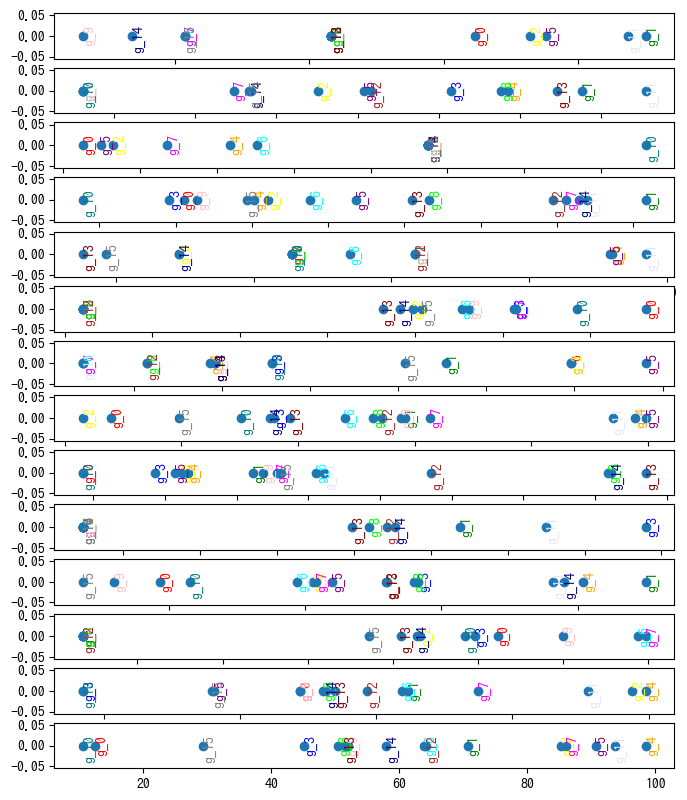

In [66]:
# plot 16 groups median
ctFeature = 0
maxCtSubplot = len(lsLsMedianInOneFeature)
ctSubplot = 1
fig = plt.figure(figsize=(8, 10), dpi=100)
for ctFeature in list(range(len(lsLsMedianInOneFeature))):
    pltFig = fig.add_subplot(maxCtSubplot, 1, ctFeature+1)
    pdSeriesMedianInOneFeature = pd.Series(lsLsMedianInOneFeature[ctFeature])
    pltFig.plot(pdSeriesMedianInOneFeature, pdSeriesMedianInOneFeature*0, "o")
    ctGroup = 0
    pdSeriesGroupNumbers = pd.Series(list(range(len(pdSeriesMedianInOneFeature))))
    for ctGroup in pdSeriesGroupNumbers:
        pltFig.text(pdSeriesMedianInOneFeature.iloc[ctGroup], 0, 
                ("g_" + str(ctGroup)),
                size=10, color=color_iterFix[ctGroup], zorder=10, rotation=90)
fig.show()